## Inference Pipeline

In [19]:
import torch
import numpy as np
from omegaconf import OmegaConf
from scripts.joint_regressor import JointRegressor
from scripts.checkpoint_utils import load_full_checkpoint
from scripts.dlrhand2_joint_datamodule import _sample_mesh_as_pc


def load_model(
    joint_ckpt: str,
    config_path: str,
    backbone_ckpt: str | None = None,
    device: str = "cuda:0"
) -> JointRegressor:
    """Instantiate JointRegressor, optionally load a JEPA backbone, then load trained joint-ckpt weights."""
    # Load training config
    cfg = OmegaConf.load(config_path)

    # Build model with training hyperparams
    model = JointRegressor(
        num_points           = cfg.data.num_points,
        tokenizer_groups     = cfg.model.tokenizer_groups,
        tokenizer_group_size = cfg.model.tokenizer_group_size,
        tokenizer_radius     = cfg.model.tokenizer_radius,
        encoder_dim          = cfg.model.encoder_dim,
        encoder_depth        = cfg.model.encoder_depth,
        encoder_heads        = cfg.model.encoder_heads,
        encoder_dropout      = cfg.model.encoder_dropout,
        encoder_attn_dropout = cfg.model.encoder_attn_dropout,
        encoder_drop_path_rate=cfg.model.encoder_drop_path_rate,
        encoder_mlp_ratio    = cfg.model.encoder_mlp_ratio,
        pooling_type         = cfg.model.pooling_type,
        pooling_heads        = cfg.model.pooling_heads,
        pooling_dropout      = 0.1,
        head_hidden_dims     = cfg.model.head_hidden_dims,
        pose_dim             = 7,
        lr_backbone          = cfg.model.lr_backbone,
        lr_head              = cfg.model.lr_head,
        weight_decay         = cfg.model.weight_decay,
        encoder_unfreeze_epoch = cfg.model.encoder_unfreeze_epoch,
        num_pred              = cfg.model.num_pred,
        loss_type            = cfg.model.loss_type,
    )

    # Load backbone pretrain if provided
    if backbone_ckpt:
        load_full_checkpoint(model, backbone_ckpt)

    # Load full joint-regression checkpoint (overwrites head + backbone)
    checkpoint = torch.load(joint_ckpt, map_location=device)
    state = checkpoint.get('state_dict', checkpoint)
    model.load_state_dict(state, strict=False)

    model.eval()
    model.freeze()
    model.to(device)
    return model


@torch.inference_mode()
def predict_joint_angles(
    model: JointRegressor,
    mesh_path: str,
    pose7d: list[float] | np.ndarray,
    num_points: int | None = None,
    device: str = "cuda:0",
) -> np.ndarray:
    """
    Given a mesh file and a 7D hand pose, returns the 12-D joint-angle prediction.
    """
    n_pts = num_points or model.hparams.num_points
    pc = _sample_mesh_as_pc(mesh_path, n=n_pts)

    pts = torch.from_numpy(pc).unsqueeze(0).to(device)
    pose = torch.as_tensor(pose7d, dtype=torch.float32).unsqueeze(0).to(device)

    if model.loss_type == "basic":
        pred_angles = model(pts, pose)
        return pred_angles
    elif model.loss_type == "min_k":
        pred_angles = model(pts, pose)
        return pred_angles
    elif model.loss_type == "min_k_logit":
        pred_angles, pred_logit = model(pts, pose)  # (B, num_pred, 12), (B,num_pred), (B,num_pred)
        pred_angles = pred_angles.squeeze(0).cpu().numpy() # (num_pred, 12)
        pred_logit = pred_logit.squeeze(0).cpu().numpy()   # (num_pred,)
        return pred_angles, pred_logit
    elif model.loss_type == "full":
        pred_angles, pred_logit, pred_score = model(pts, pose)
        pred_angles = pred_angles.squeeze(0).cpu().numpy() # (num_pred, 12)
        pred_logit = pred_logit.squeeze(0).cpu().numpy()   # (num_pred,)
        pred_score = pred_score.squeeze(0).cpu().numpy()   # (num_pred,)
        return pred_angles, pred_logit, pred_score
    else:
        raise ValueError(f"Unknown loss type '{model.loss_type}'. Available types: "
                        f"basic, min_k, attention, min_k_logit, full")

# Example usage:
# model = load_model(
#     joint_ckpt="checkpoints/joint-final.ckpt",
#     config_path="configs/train_joint.yaml",
#     backbone_ckpt="checkpoints/pretrain-pointjepa.ckpt",  # optional
#     device="cuda:0"
# )
# angles = predict_joint_angles(model, mesh_path, hand_pose)
# print(angles)


### Prediction Visualization

Using DIRECT mode, client ID: 4

 Closest to ground truth prediction: 
 [ 0.08167  0.57    -0.1237  -0.1154   0.7124  -0.1882  -0.2957   0.672
 -0.1981  -0.2954   0.3403  -0.1597 ]

 Inference time prediction: 
 [ 0.08167  0.57    -0.1237  -0.1154   0.7124  -0.1882  -0.2957   0.672
 -0.1981  -0.2954   0.3403  -0.1597 ]
Grasp 0:
    palm  (xyz, qxqyqzqw) = [-0.046, -0.009, 0.27, -0.066, 0.976, 0.004, 0.208]
    joints (12 angles)  = [[-0.9658203125, -0.154052734375, -0.01200103759765625, 1.3017578125, 1.623046875, 0.22802734375, 0.662109375, -0.1419677734375, 0.061004638671875, 0.489990234375, 0.14599609375, -0.11602783203125], [0.3720703125, 0.96923828125, 1.1748046875, 0.25, 1.1376953125, 1.3828125, 0.0889892578125, 0.1719970703125, 0.2430419921875, -0.040008544921875, -0.004001617431640625, 0.114013671875], [0.362060546875, 1.4033203125, 1.642578125, 0.126953125, -0.01000213623046875, 0.2230224609375, -0.08197021484375, 0.055999755859375, 0.1529541015625, -0.18603515625, 0.0819702148

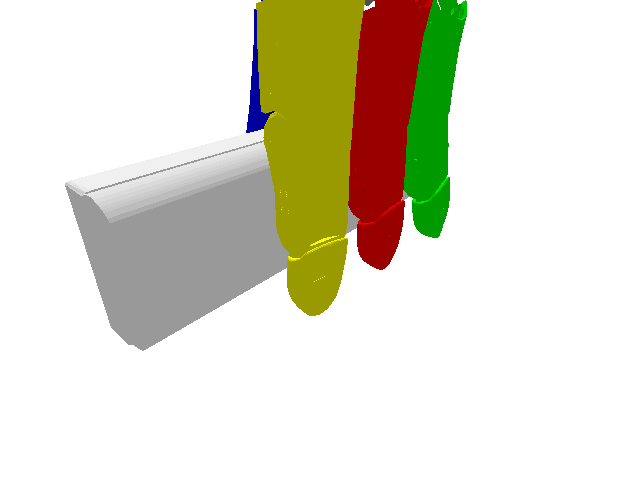


 Closest to ground truth prediction: 
 [ 0.0802  0.58   -0.1285 -0.1149  0.7217 -0.1927 -0.294   0.679  -0.2017
 -0.296   0.3455 -0.1626]

 Inference time prediction: 
 [ 0.0802  0.58   -0.1285 -0.1149  0.7217 -0.1927 -0.294   0.679  -0.2017
 -0.296   0.3455 -0.1626]
Grasp 1:
    palm  (xyz, qxqyqzqw) = [-0.042, 0.021, 0.277, -0.064, 0.979, -0.056, 0.186]
    joints (12 angles)  = [[-0.89794921875, -0.1429443359375, 0.01399993896484375, 1.228515625, 1.53125, 0.2249755859375, 0.60400390625, -0.12298583984375, 0.04998779296875, 0.43603515625, 0.125, -0.093994140625], [0.3701171875, 0.953125, 1.1572265625, 0.2490234375, 1.1279296875, 1.3720703125, 0.09100341796875, 0.1920166015625, 0.2320556640625, -0.045989990234375, -0.01399993896484375, 0.1099853515625], [0.363037109375, 1.40234375, 1.6416015625, 0.1259765625, 0.0030002593994140625, 0.2159423828125, -0.0789794921875, 0.07098388671875, 0.14404296875, -0.1839599609375, 0.083984375, 0.0149993896484375], [0.08001708984375, -0.096008300781

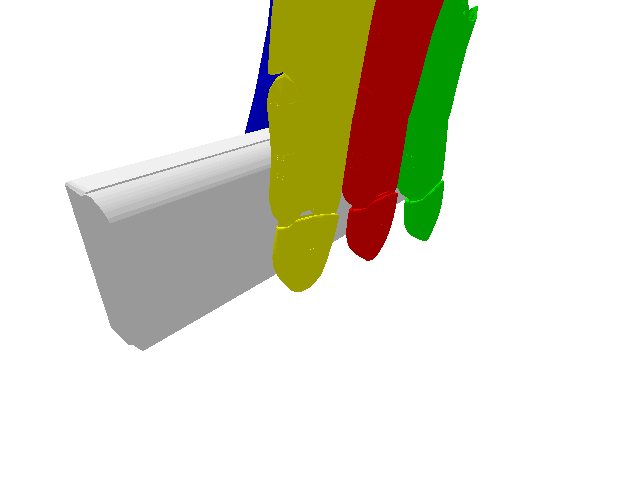


 Closest to ground truth prediction: 
 [ 0.3616   1.405    1.646    0.1277  -0.0213   0.231   -0.0846   0.0421
  0.1641  -0.1895   0.0799   0.02153]

 Inference time prediction: 
 [ 0.08344  0.56    -0.1162  -0.1148   0.703   -0.18    -0.2961   0.6636
 -0.1904  -0.2947   0.3323  -0.1527 ]
Grasp 2:
    palm  (xyz, qxqyqzqw) = [-0.239, 0.04, 0.143, 0.53, 0.638, 0.172, 0.532]
    joints (12 angles)  = [[-1.044921875, -0.16796875, -0.035003662109375, 1.39453125, 1.7373046875, 0.22802734375, 0.73388671875, -0.1590576171875, 0.07501220703125, 0.544921875, 0.1700439453125, -0.135009765625], [0.3740234375, 0.9921875, 1.2021484375, 0.2509765625, 1.1513671875, 1.400390625, 0.08599853515625, 0.1519775390625, 0.256103515625, -0.03399658203125, 0.01000213623046875, 0.1190185546875], [0.362060546875, 1.4052734375, 1.646484375, 0.1280517578125, -0.02099609375, 0.23095703125, -0.08502197265625, 0.0419921875, 0.1639404296875, -0.18994140625, 0.08001708984375, 0.022003173828125], [0.0789794921875, -0.1

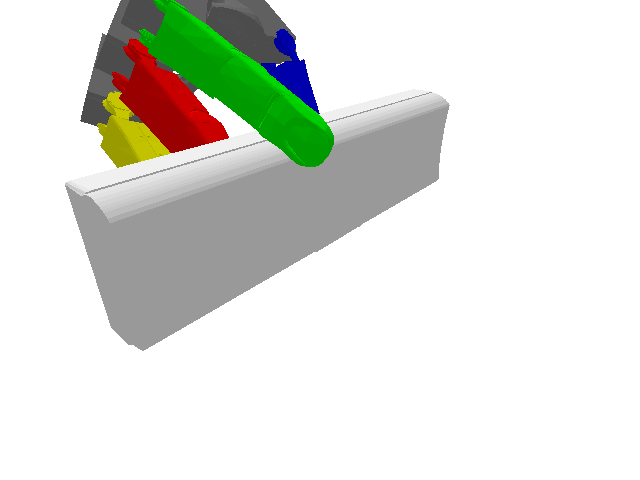


 Closest to ground truth prediction: 
 [ 0.0844   0.5547  -0.11194 -0.1144   0.698   -0.1754  -0.2961   0.659
 -0.186   -0.2944   0.328   -0.1487 ]

 Inference time prediction: 
 [ 0.0844   0.5547  -0.11194 -0.1144   0.698   -0.1754  -0.2961   0.659
 -0.186   -0.2944   0.328   -0.1487 ]
Grasp 3:
    palm  (xyz, qxqyqzqw) = [0.008, -0.006, 0.295, -0.053, 0.998, -0.013, 0.011]
    joints (12 angles)  = [[-1.0888671875, -0.175048828125, -0.0469970703125, 1.4462890625, 1.8017578125, 0.22802734375, 0.77392578125, -0.1689453125, 0.0830078125, 0.576171875, 0.1829833984375, -0.14501953125], [0.375, 1.0048828125, 1.216796875, 0.251953125, 1.16015625, 1.4091796875, 0.08502197265625, 0.1409912109375, 0.261962890625, -0.031005859375, 0.01800537109375, 0.12200927734375], [0.361083984375, 1.40625, 1.6484375, 0.1280517578125, -0.0269927978515625, 0.2349853515625, -0.08599853515625, 0.03399658203125, 0.1700439453125, -0.1910400390625, 0.0789794921875, 0.0240020751953125], [0.0789794921875, -0.1110229

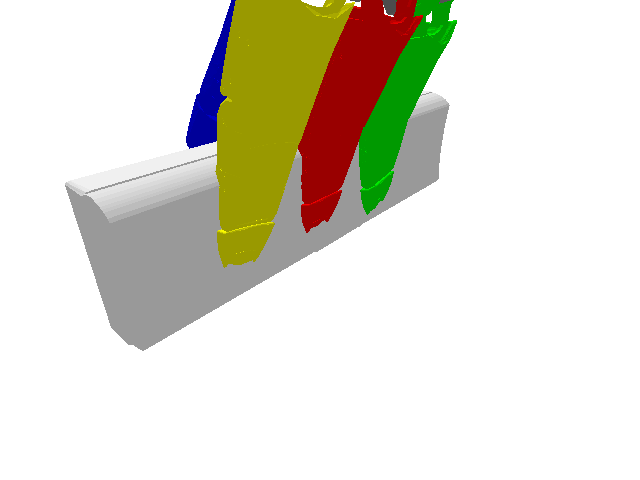


 Closest to ground truth prediction: 
 [ 0.0868   0.541   -0.10144 -0.1134   0.6855  -0.164   -0.2966   0.6484
 -0.175   -0.2932   0.3167  -0.1388 ]

 Inference time prediction: 
 [ 0.0868   0.541   -0.10144 -0.1134   0.6855  -0.164   -0.2966   0.6484
 -0.175   -0.2932   0.3167  -0.1388 ]
Grasp 4:
    palm  (xyz, qxqyqzqw) = [0.005, -0.008, 0.291, 0.996, 0.063, -0.034, 0.046]
    joints (12 angles)  = [[-1.197265625, -0.1939697265625, -0.0770263671875, 1.57421875, 1.9599609375, 0.22705078125, 0.873046875, -0.1920166015625, 0.10198974609375, 0.65087890625, 0.2159423828125, -0.1710205078125], [0.3779296875, 1.0361328125, 1.25390625, 0.2529296875, 1.1796875, 1.4326171875, 0.08197021484375, 0.11297607421875, 0.279052734375, -0.0229949951171875, 0.0369873046875, 0.1290283203125], [0.360107421875, 1.4091796875, 1.65234375, 0.1280517578125, -0.042999267578125, 0.2449951171875, -0.09002685546875, 0.0149993896484375, 0.18603515625, -0.1949462890625, 0.07598876953125, 0.0290069580078125], [0.07

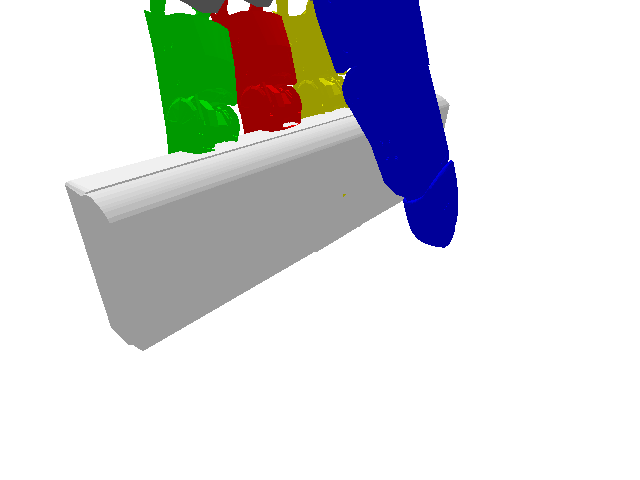


 Closest to ground truth prediction: 
 [ 0.3733   0.9883   1.197    0.2507   1.149    1.397    0.08685  0.1549
  0.2537  -0.03537  0.00793  0.1186 ]

 Inference time prediction: 
 [ 0.0831   0.5615  -0.1174  -0.11487  0.7046  -0.1814  -0.2961   0.665
 -0.1917  -0.295    0.3335  -0.1538 ]
Grasp 5:
    palm  (xyz, qxqyqzqw) = [-0.044, -0.007, 0.29, 0.596, 0.794, 0.004, 0.118]
    joints (12 angles)  = [[-1.033203125, -0.166015625, -0.031005859375, 1.3798828125, 1.7197265625, 0.22802734375, 0.72314453125, -0.156005859375, 0.072998046875, 0.5361328125, 0.1669921875, -0.1319580078125], [0.373046875, 0.98779296875, 1.197265625, 0.2509765625, 1.1494140625, 1.3974609375, 0.08697509765625, 0.155029296875, 0.25390625, -0.035003662109375, 0.00800323486328125, 0.1190185546875], [0.362060546875, 1.4052734375, 1.646484375, 0.1280517578125, -0.0200042724609375, 0.22998046875, -0.083984375, 0.04400634765625, 0.1619873046875, -0.18896484375, 0.08001708984375, 0.02099609375], [0.0789794921875, -0.10797

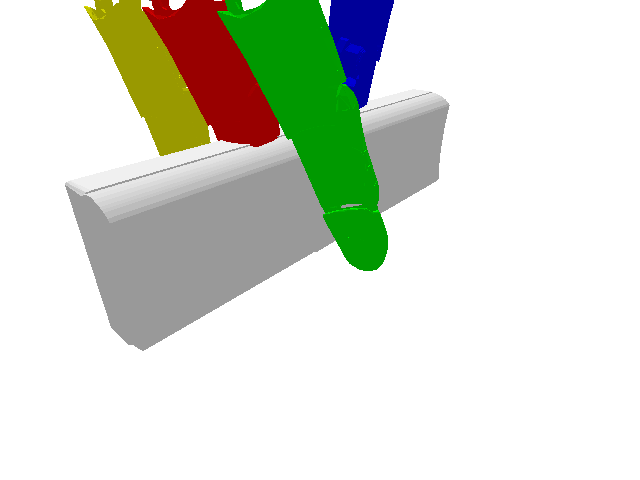


 Closest to ground truth prediction: 
 [ 0.0817   0.5693  -0.12366 -0.1155   0.7124  -0.1882  -0.296    0.6714
 -0.1982  -0.2954   0.34    -0.1599 ]

 Inference time prediction: 
 [ 0.0817   0.5693  -0.12366 -0.1155   0.7124  -0.1882  -0.296    0.6714
 -0.1982  -0.2954   0.34    -0.1599 ]
Grasp 6:
    palm  (xyz, qxqyqzqw) = [0.017, 0.034, 0.285, 0.989, 0.038, -0.116, 0.078]
    joints (12 angles)  = [[-0.9677734375, -0.155029296875, -0.01300048828125, 1.3037109375, 1.6259765625, 0.22802734375, 0.6640625, -0.1419677734375, 0.061004638671875, 0.491943359375, 0.14697265625, -0.11700439453125], [0.3720703125, 0.96923828125, 1.17578125, 0.25, 1.1376953125, 1.3828125, 0.0889892578125, 0.1710205078125, 0.2440185546875, -0.040008544921875, -0.004001617431640625, 0.114990234375], [0.362060546875, 1.4033203125, 1.642578125, 0.126953125, -0.01000213623046875, 0.2239990234375, -0.08197021484375, 0.055999755859375, 0.1529541015625, -0.18603515625, 0.08197021484375, 0.01800537109375], [0.080017089

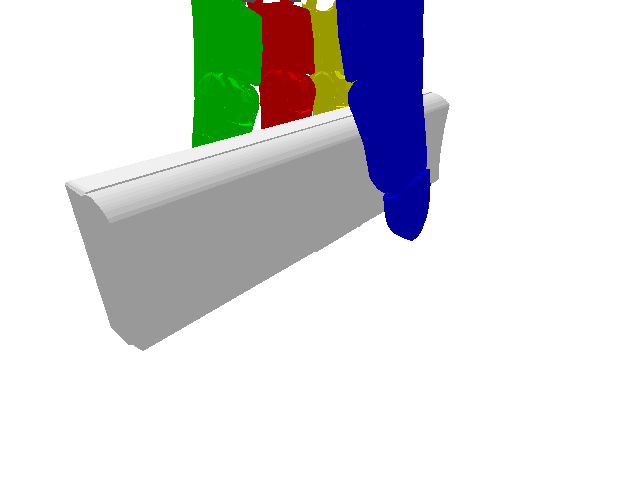


 Closest to ground truth prediction: 
 [ 0.08685  0.541   -0.1012  -0.1134   0.685   -0.1638  -0.2966   0.648
 -0.1748  -0.2932   0.3164  -0.1385 ]

 Inference time prediction: 
 [ 0.08685  0.541   -0.1012  -0.1134   0.685   -0.1638  -0.2966   0.648
 -0.1748  -0.2932   0.3164  -0.1385 ]
Grasp 7:
    palm  (xyz, qxqyqzqw) = [0.003, 0.047, 0.286, 0.992, 0.042, -0.078, 0.089]
    joints (12 angles)  = [[-1.19921875, -0.1939697265625, -0.0770263671875, 1.5771484375, 1.962890625, 0.22705078125, 0.875, -0.1929931640625, 0.10302734375, 0.65185546875, 0.2159423828125, -0.1710205078125], [0.3779296875, 1.037109375, 1.2548828125, 0.2529296875, 1.1806640625, 1.43359375, 0.08197021484375, 0.11297607421875, 0.280029296875, -0.0229949951171875, 0.0369873046875, 0.1290283203125], [0.360107421875, 1.4091796875, 1.65234375, 0.1280517578125, -0.042999267578125, 0.2459716796875, -0.09002685546875, 0.0149993896484375, 0.18603515625, -0.1949462890625, 0.07598876953125, 0.0290069580078125], [0.078002929687

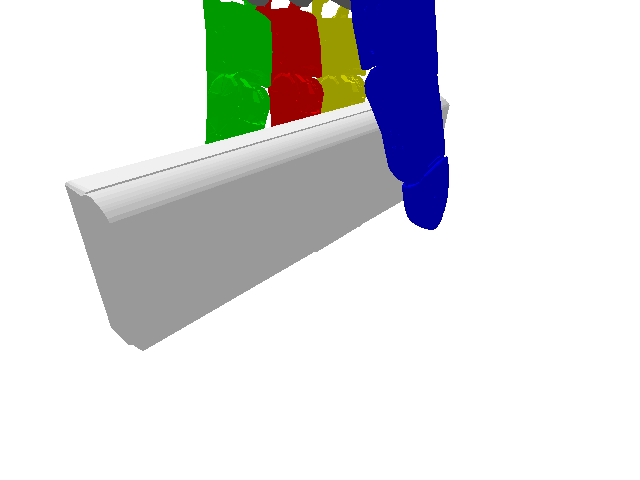


 Closest to ground truth prediction: 
 [ 0.07947  0.5884  -0.1284  -0.11304  0.728   -0.1915  -0.2908   0.684
 -0.1985  -0.296    0.346   -0.1593 ]

 Inference time prediction: 
 [ 0.07947  0.5884  -0.1284  -0.11304  0.728   -0.1915  -0.2908   0.684
 -0.1985  -0.296    0.346   -0.1593 ]
Grasp 8:
    palm  (xyz, qxqyqzqw) = [0.011, 0.084, 0.281, 0.977, 0.034, -0.114, 0.179]
    joints (12 angles)  = [[-0.85986328125, -0.136962890625, 0.040985107421875, 1.2001953125, 1.4912109375, 0.218017578125, 0.576171875, -0.1090087890625, 0.045013427734375, 0.39794921875, 0.11199951171875, -0.07501220703125], [0.3701171875, 0.9501953125, 1.1552734375, 0.25, 1.1259765625, 1.3701171875, 0.09197998046875, 0.2060546875, 0.2230224609375, -0.048004150390625, -0.01800537109375, 0.10699462890625], [0.362060546875, 1.4033203125, 1.6435546875, 0.125, 0.0160064697265625, 0.2110595703125, -0.0780029296875, 0.0830078125, 0.1390380859375, -0.1839599609375, 0.08697509765625, 0.01300048828125], [0.0789794921875, -

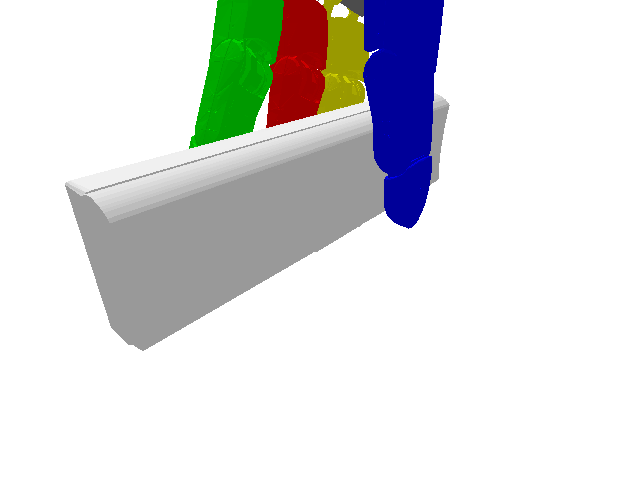


 Closest to ground truth prediction: 
 [ 0.0837  0.5586 -0.1151 -0.1147  0.7017 -0.179  -0.2961  0.6626 -0.1893
 -0.2947  0.331  -0.1517]

 Inference time prediction: 
 [ 0.0837  0.5586 -0.1151 -0.1147  0.7017 -0.179  -0.2961  0.6626 -0.1893
 -0.2947  0.331  -0.1517]
Grasp 9:
    palm  (xyz, qxqyqzqw) = [0.034, 0.018, 0.268, 0.977, 0.076, -0.191, 0.047]
    joints (12 angles)  = [[-1.056640625, -0.1700439453125, -0.037994384765625, 1.408203125, 1.75390625, 0.22802734375, 0.744140625, -0.1619873046875, 0.0770263671875, 0.55322265625, 0.1739501953125, -0.137939453125], [0.3740234375, 0.9951171875, 1.2060546875, 0.2509765625, 1.154296875, 1.40234375, 0.08599853515625, 0.1490478515625, 0.257080078125, -0.03399658203125, 0.01200103759765625, 0.1199951171875], [0.362060546875, 1.4052734375, 1.646484375, 0.1280517578125, -0.0229949951171875, 0.2320556640625, -0.08502197265625, 0.040008544921875, 0.166015625, -0.18994140625, 0.08001708984375, 0.022003173828125], [0.0789794921875, -0.109008789

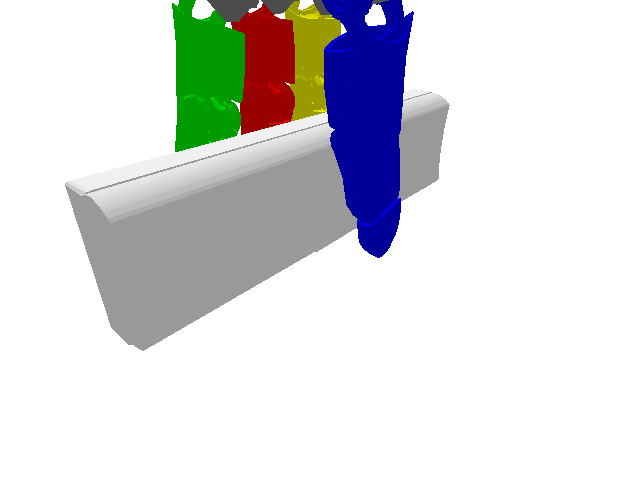

In [23]:
import pybullet as p, pybullet_data
import numpy as np
from pathlib import Path
from PIL import Image
from IPython.display import display
import time

# ── 1) Define your real data folder here ──
# not in the split_50, split_10
root = Path("../data/studentGrasping/student_grasps_v1/03211117/2f12da0c7460b22cd3ab2bc0f53ca878/3")

# not in the split_25, split_10
# root = Path("../data/studentGrasping/student_grasps_v1/03211117/9329eb153c1e8b4d8479362ee6ff3679/7")

# not in the split_10
# root = Path("../data/studentGrasping/student_grasps_v1/04401088/4a0cd042d7479d6810bc2436075f6a52/2")

mesh_f = root / "mesh.obj"
recording = root / "recording.npz"

assert mesh_f.exists(), f"Mesh not found at {mesh_f}"
assert recording.exists(), f"Recording not found at {recording}"

# ── 2) Connect headlessly ──
cid = p.connect(p.DIRECT)
print("Using DIRECT mode, client ID:", cid)

p.setAdditionalSearchPath(pybullet_data.getDataPath())
p.resetSimulation(physicsClientId=cid)

# ── 3) Load your hand URDF once ──
hand_id = p.loadURDF(
    str(Path("../urdfs/dlr2.urdf").absolute()),  # update if your urdf is elsewhere
    useFixedBase=True,
    flags=p.URDF_MAINTAIN_LINK_ORDER,
    physicsClientId=cid,
)

# ── 4) Load object mesh once ──
v = p.createVisualShape(
    shapeType=p.GEOM_MESH,
    fileName=str(mesh_f.resolve()),
    meshScale=1.0,
    physicsClientId=cid,
)
c = p.createCollisionShape(
    shapeType=p.GEOM_MESH,
    fileName=str(mesh_f.resolve()),
    meshScale=1.0,
    physicsClientId=cid,
)
p.createMultiBody(
    baseVisualShapeIndex=v,
    baseCollisionShapeIndex=c,
    basePosition=[0,0,0],
    baseOrientation=[0,0,0,1],
    physicsClientId=cid,
)

# ── 5) Prepare model & data ──
model = load_model(
    joint_ckpt="../configs/checkpoints/epoch=9-step=8090.ckpt",
    config_path="../configs/train_joint.yaml",
    device="cuda:0",
)
model.eval()

data    = np.load(recording, allow_pickle=False)
grasps  = data["grasps"]    # shape (24,19)
scores  = data["scores"]    # shape (24,)

poses7d = grasps[:10, :7]             # hand poses
angles12 = grasps[:10, 7:19]          # joint angles - ground truth, just for comparison
scores_n = scores[:10]                # scores

# DLR-II finger joint indices and coupled set
JOINT_INDICES = [1,2,3, 7,8,9, 13,14,15, 19,20,21]
COUPLED       = {3,9,15,21}

# ── 6) Render loop ──
for i, pose7d in enumerate(poses7d):
    if model.loss_type == "basic":
        angles = predict_joint_angles(model, mesh_path=str(mesh_f), pose7d=pose7d)
    elif model.loss_type == "min_k":
        angles = predict_joint_angles(model, mesh_path=str(mesh_f), pose7d=pose7d)
    elif model.loss_type == "min_k_logit":
        angles, logits = predict_joint_angles(model, mesh_path=str(mesh_f), pose7d=pose7d)
    elif model.loss_type == "min_k_logit":
        angles, logits, scores = predict_joint_angles(model, mesh_path=str(mesh_f), pose7d=pose7d)

    distances = np.linalg.norm(angles - angles12[i], axis=1)  # shape: (K,)
    best_k = np.argmin(distances)
    best_prediction = angles[best_k] 
    print("\n Closest to ground truth prediction: \n",best_prediction)

    max_logit = np.argmax(logits)
    inference_prediction = angles[max_logit]
    print("\n Inference time prediction: \n", inference_prediction)

    # reset pose & joints
    p.resetBasePositionAndOrientation(hand_id, pose7d[:3], pose7d[3:], physicsClientId=cid)
    for a, j in zip(inference_prediction, [1,2,3,7,8,9,13,14,15,19,20,21]):
        p.resetJointState(hand_id, j, a, physicsClientId=cid)
        if j in {3,9,15,21}:
            p.resetJointState(hand_id, j+1, a, physicsClientId=cid)
    p.stepSimulation(physicsClientId=cid)

    # snapshot
    view = p.computeViewMatrixFromYawPitchRoll(
        cameraTargetPosition=[0,0,0], distance=0.3,
        yaw=45, pitch=-30, roll=0, upAxisIndex=2,
        physicsClientId=cid
    )
    proj = p.computeProjectionMatrixFOV(
        fov=60, aspect=640/480, nearVal=0.01, farVal=1.5,
        physicsClientId=cid
    )
    w, h, rgba, _, _ = p.getCameraImage(640, 480,
                                        viewMatrix=view,
                                        projectionMatrix=proj,
                                        physicsClientId=cid)
    img = Image.fromarray(rgba[:, :, :3])

    print(f"Grasp {i}:")
    print(f"    palm  (xyz, qxqyqzqw) = {pose7d.round(3).tolist()}")
    print(f"    joints (12 angles)  = {np.round(angles,3).tolist()}")
    display(img)
    time.sleep(0.5)

p.disconnect(physicsClientId=cid)


### Ground Truth Prediction Visualization

Grasp 0: score = 0.451
    palm  (xyz, qxqyqzqw) = [-0.099, 0.012, 0.262, 0.691, 0.691, -0.053, 0.205]
    joints (12 angles)  = [0.502, 0.721, 0.337, 0.332, 0.741, 0.292, -0.239, 0.801, -0.154, -0.018, -0.079, 0.044]


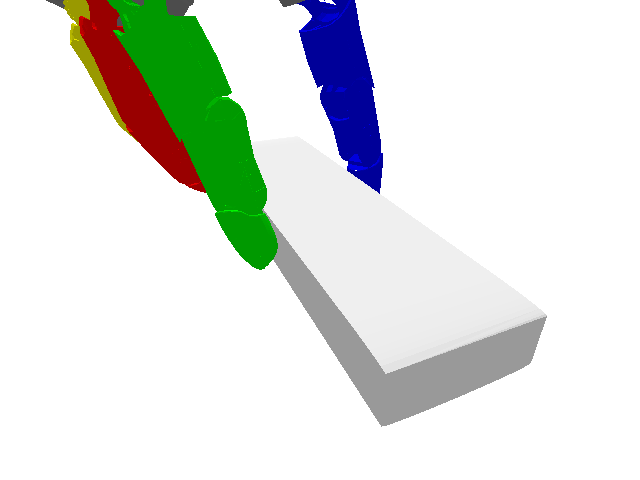

Grasp 1: score = -0.000
    palm  (xyz, qxqyqzqw) = [-0.032, 0.059, 0.275, 0.194, 0.965, -0.029, 0.173]
    joints (12 angles)  = [0.379, 0.551, -0.04, 0.284, -0.069, 0.131, 0.072, -0.069, -0.051, -0.456, -0.119, -0.161]


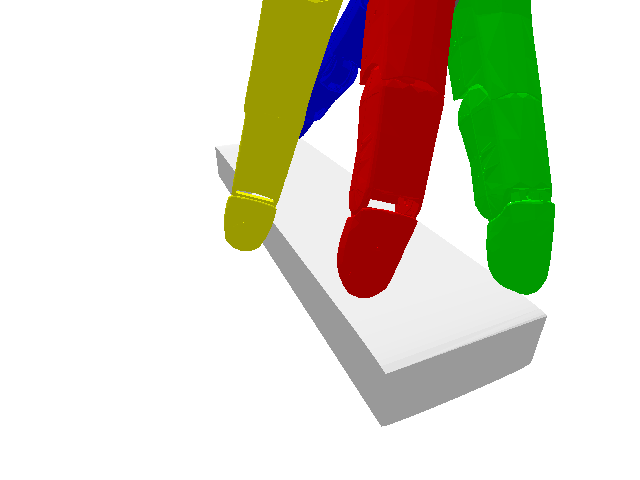

Grasp 2: score = -0.000
    palm  (xyz, qxqyqzqw) = [-0.07, 0.023, 0.255, 0.179, 0.968, 0.029, 0.171]
    joints (12 angles)  = [0.469, 1.501, 1.825, 0.395, -0.229, 0.148, 0.381, -0.229, -0.085, -0.505, -0.159, -0.131]


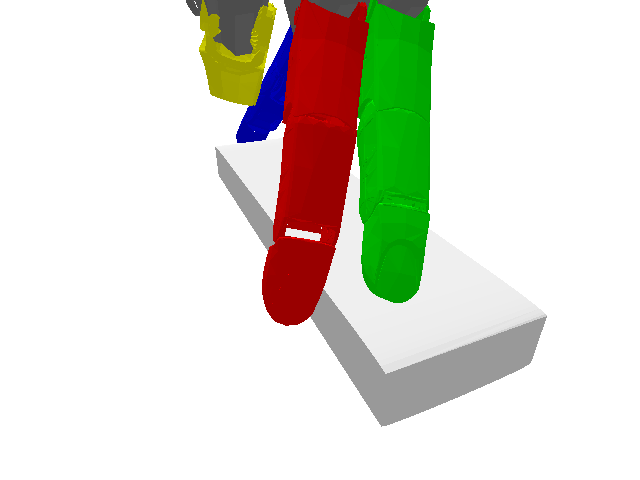

Grasp 3: score = 2.634
    palm  (xyz, qxqyqzqw) = [-0.001, 0.036, 0.27, 0.784, 0.587, -0.139, 0.149]
    joints (12 angles)  = [0.205, 0.621, -0.086, -0.005, 0.751, -0.126, -0.234, 0.671, -0.079, -0.318, 0.081, 0.053]


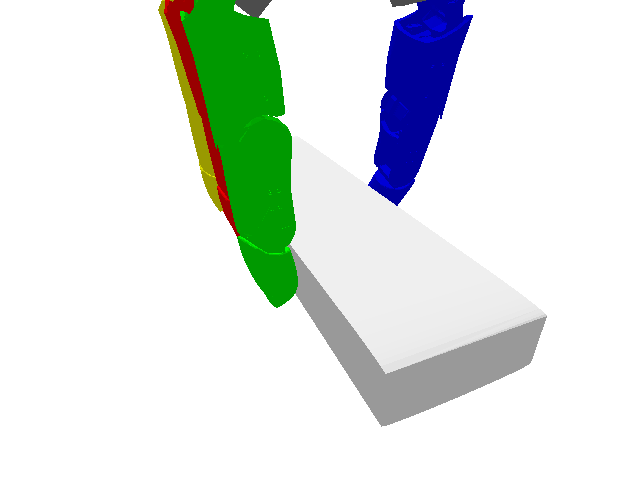

Grasp 4: score = 2.512
    palm  (xyz, qxqyqzqw) = [-0.008, 0.056, 0.271, 0.783, 0.591, -0.126, 0.149]
    joints (12 angles)  = [0.277, 0.401, 0.001, -0.091, 0.591, -0.134, -0.229, 0.471, -0.017, -0.276, 0.381, -0.145]


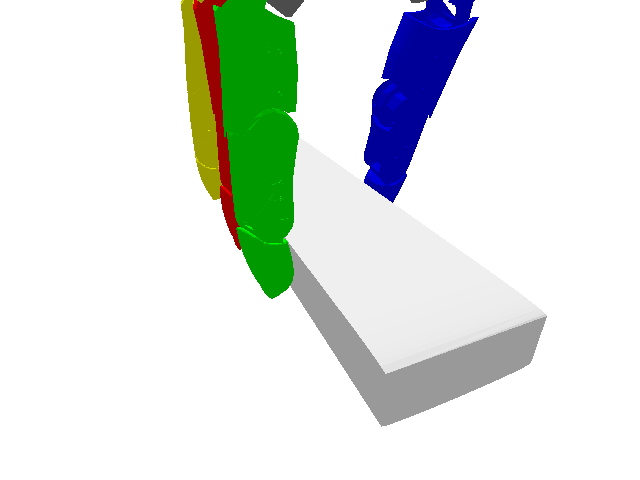

Grasp 5: score = 1.162
    palm  (xyz, qxqyqzqw) = [-0.07, 0.063, 0.267, 0.755, 0.619, -0.063, 0.208]
    joints (12 angles)  = [0.52, 0.001, 0.66, 0.511, 0.461, 0.084, 0.007, 0.551, -0.119, -0.236, 0.361, -0.149]


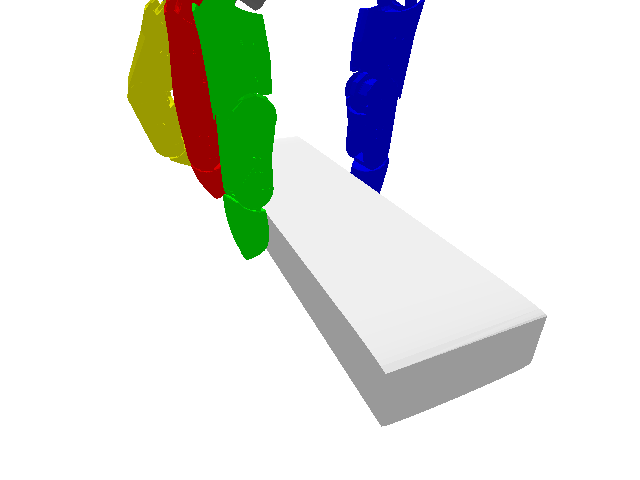

Grasp 6: score = 2.628
    palm  (xyz, qxqyqzqw) = [0.001, 0.033, 0.271, 0.783, 0.589, -0.141, 0.143]
    joints (12 angles)  = [0.143, 0.651, -0.104, -0.055, 0.741, -0.118, -0.282, 0.721, -0.154, -0.312, 0.091, 0.034]


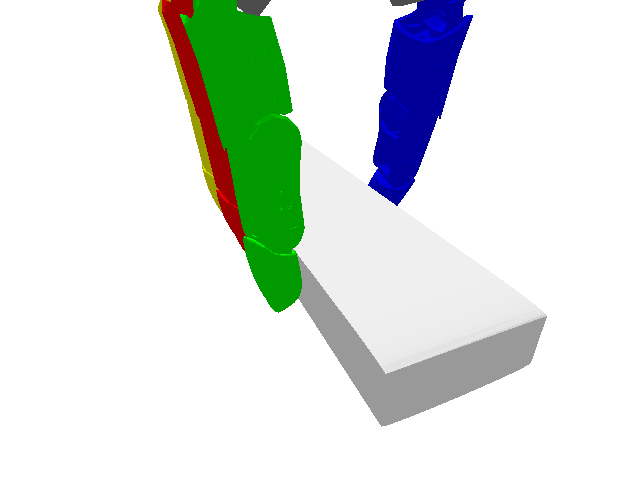

Grasp 7: score = 2.549
    palm  (xyz, qxqyqzqw) = [0.012, 0.062, 0.27, 0.807, 0.556, -0.141, 0.14]
    joints (12 angles)  = [0.169, 0.271, 0.06, 0.048, 0.511, -0.125, -0.283, 0.461, -0.038, -0.296, 0.451, -0.162]


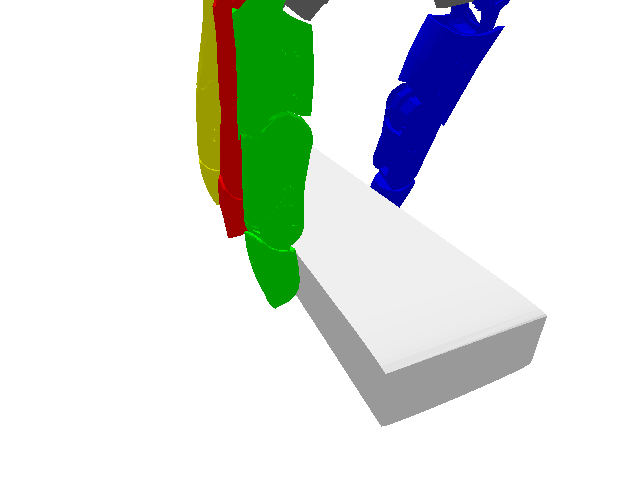

Grasp 8: score = 2.548
    palm  (xyz, qxqyqzqw) = [-0.002, 0.059, 0.271, 0.788, 0.583, -0.13, 0.149]
    joints (12 angles)  = [0.205, 0.491, -0.162, -0.077, 0.561, -0.119, -0.195, 0.431, 0.031, -0.28, 0.401, -0.15]


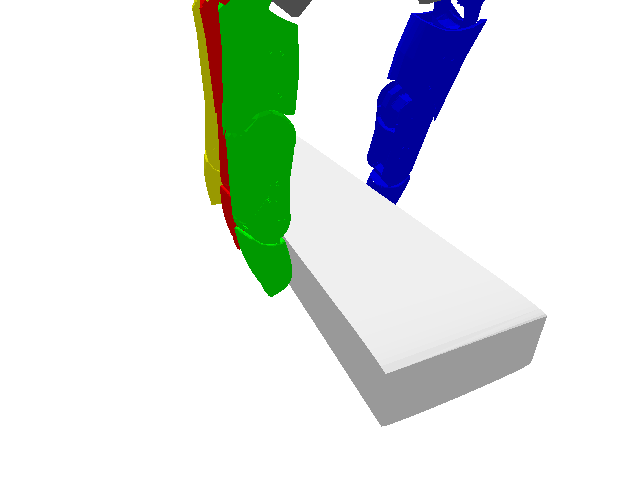

Grasp 9: score = 2.185
    palm  (xyz, qxqyqzqw) = [0.029, 0.054, 0.27, 0.793, 0.593, -0.127, 0.055]
    joints (12 angles)  = [0.008, 0.091, 0.112, -0.387, 0.041, 0.241, -0.519, -0.039, 0.281, -0.229, 0.651, -0.17]


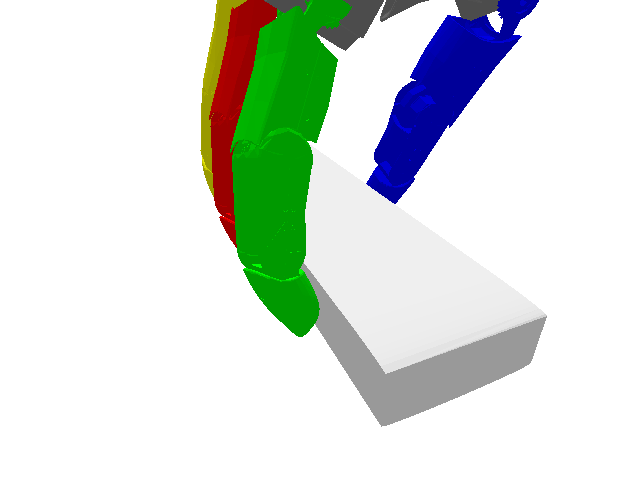

In [17]:
import pybullet as p, pybullet_data
import numpy as np
from pathlib import Path
from PIL import Image
from IPython.display import display
import time

# ── 1) Point to your data folder ──
# not in the split_50
# root      = Path("../data/grasp_sample/03211117/2f12da0c7460b22cd3ab2bc0f53ca878/3")

# not in the split_25
# root  = Path("../data/studentGrasping/student_grasps_v1/03211117/9329eb153c1e8b4d8479362ee6ff3679/7")

# not in the split_10
root = Path("../data/studentGrasping/student_grasps_v1/04401088/4a0cd042d7479d6810bc2436075f6a52/2")

mesh_f    = root / "mesh.obj"
recording = root / "recording.npz"
assert mesh_f.exists(),    f"Mesh not found at {mesh_f}"
assert recording.exists(), f"Recording not found at {recording}"

# ── 2) Connect headlessly ──
cid = p.connect(p.DIRECT)
p.setAdditionalSearchPath(pybullet_data.getDataPath())
p.resetSimulation(physicsClientId=cid)

# ── 3) Load the hand URDF once ──
hand_id = p.loadURDF(
    str(Path("../urdfs/dlr2.urdf").absolute()),
    useFixedBase=True,
    flags=p.URDF_MAINTAIN_LINK_ORDER,
    physicsClientId=cid,
)

# ── 4) Load the object mesh once ──
v = p.createVisualShape(p.GEOM_MESH, fileName=str(mesh_f.resolve()), meshScale=1.0, physicsClientId=cid)
c = p.createCollisionShape(p.GEOM_MESH, fileName=str(mesh_f.resolve()), meshScale=1.0, physicsClientId=cid)
p.createMultiBody(baseVisualShapeIndex=v, baseCollisionShapeIndex=c,
                  basePosition=[0,0,0], baseOrientation=[0,0,0,1],
                  physicsClientId=cid)

# ── 5) Load recorded grasps & scores ──
data    = np.load(recording, allow_pickle=False)
grasps  = data["grasps"]    # shape (24,19)
scores  = data["scores"]    # shape (24,)

n        = min(10, grasps.shape[0])  # show up to first 10
poses7d  = grasps[:n, :7]            # palm pose
angles12 = grasps[:n, 7:19]          # joint angles
scores_n = scores[:n]                # scores

# DLR-II finger joint indices and coupled set
JOINT_INDICES = [1,2,3, 7,8,9, 13,14,15, 19,20,21]
COUPLED       = {3,9,15,21}

# ── 6) Render loop with score printout ──
for i, (pose7d, angles, score) in enumerate(zip(poses7d, angles12, scores_n)):
    # reset hand base pose
    p.resetBasePositionAndOrientation(hand_id, pose7d[:3], pose7d[3:], physicsClientId=cid)
    # reset all 12 finger joints (and their coupled partners)
    for a, j in zip(angles, JOINT_INDICES):
        p.resetJointState(hand_id, j, a, physicsClientId=cid)
        if j in COUPLED:
            p.resetJointState(hand_id, j+1, a, physicsClientId=cid)
    p.stepSimulation(physicsClientId=cid)

    # grab a quick camera frame
    view = p.computeViewMatrixFromYawPitchRoll(
        cameraTargetPosition=[0,0,0], distance=0.3,
        yaw=45, pitch=-30, roll=0, upAxisIndex=2,
        physicsClientId=cid
    )
    proj = p.computeProjectionMatrixFOV(
        fov=60, aspect=640/480, nearVal=0.01, farVal=1.5,
        physicsClientId=cid
    )
    _, _, rgba, _, _ = p.getCameraImage(
        640, 480,
        viewMatrix=view, projectionMatrix=proj,
        physicsClientId=cid
    )
    img = Image.fromarray(rgba[:, :, :3])

    # print score, palm pose, and joint angles
    print(f"Grasp {i}: score = {score:.3f}")
    print(f"    palm  (xyz, qxqyqzqw) = {pose7d.round(3).tolist()}")
    print(f"    joints (12 angles)  = {np.round(angles,3).tolist()}")
    display(img)

    time.sleep(0.5)  # pause so you can visually inspect each grasp

p.disconnect(physicsClientId=cid)


In [15]:
model = load_model(
    joint_ckpt="../configs/checkpoints/jepa_no_FT.ckpt",            # your trained regressor
    config_path="../configs/train_joint.yaml",
    #backbone_ckpt="checkpoints/pretrain_pointjepa.ckpt",  # if you want to override backbone first
    device="cuda:0",
)

angles = predict_joint_angles(
    model,
    mesh_path="../data/grasp_sample/02818832/4bc7ad3dbb8fc8747d8864caa856253b/0/mesh.obj",
    pose7d=[0.035, -0.01, 0.07, 0.0, 0.0, 0.0, 1.0],
)
print("Predicted joint angles:", angles)


Predicted joint angles: [-0.149     0.1322   -0.2136    0.09985  -0.1733   -0.04956   0.03072
 -0.09595   0.008736  0.028    -0.10754  -0.02014 ]


## PyBullet Script

In [16]:
"""
grasp_vis.py
============

Tiny utility to render a single grasp with the DLR-II hand in PyBullet.

Usage from a script / notebook
------------------------------
model = load_model(...)

pose7d  = [0.035, -0.01, 0.07, 0.0, 0.0, 0.0, 1.0]          # xyz + quaternion
mesh    = "../data/grasp_sample/02818832/.../mesh.obj"

predict_and_visualize(model, mesh, pose7d, hand_urdf="urdfs/dlr2.urdf")
"""

from pathlib import Path
import numpy as np
import pybullet as p
import pybullet_data
import argparse
from typing import Sequence

# order expected by the DLR-II URDF (same as the supervisor’s script)
_HAND_JOINT_INDICES = [1, 2, 3, 7, 8, 9, 13, 14, 15, 19, 20, 21]
_COUPLED_JOINTS     = {3, 9, 15, 21}        # They also drive j+1

def _ensure_connection(gui: bool = True) -> int:
    """Connect to PyBullet once and return the client id."""
    if p.isConnected():
        return p.getConnectionInfo()['clientIndex']
    connection_mode = p.GUI if gui else p.DIRECT
    return p.connect(connection_mode)


def visualize_grasp(
        mesh_path: str | Path,
        pose7d: Sequence[float],
        joint_angles: Sequence[float],
        *,
        hand_urdf: str = "urdfs/dlr2.urdf",
        object_mass: float = 1.0,
        mesh_scale: float | Sequence[float] = 1.0,
        wait_for_input: bool = True,
) -> None:
    """
    Show a single grasp in PyBullet.

    Parameters
    ----------
    mesh_path        : path to the object mesh (.obj)
    pose7d           : (x, y, z, qx, qy, qz, qw) world-space hand base pose
    joint_angles     : iterable of 12 angles in radians (DLR-II finger order)
    hand_urdf        : path to hand URDF
    object_mass      : mass (kg) given to the visual/collision mesh
    mesh_scale       : uniform or xyz scale factor for the mesh
    wait_for_input   : if True, waits for <Enter> before exiting
    """
    if len(pose7d) != 7:
        raise ValueError("pose7d must have 7 elements (xyz + quaternion)")
    if len(joint_angles) != 12:
        raise ValueError("joint_angles must have 12 elements")

    _ensure_connection(gui=True)
    p.resetSimulation()                              # fresh scene
    p.setAdditionalSearchPath(pybullet_data.getDataPath())

    # ------------------------------------------------------------------ hand
    hand_id = p.loadURDF(
        hand_urdf,
        globalScaling=1,
        basePosition=pose7d[:3],
        baseOrientation=pose7d[3:],
        useFixedBase=True,
        flags=p.URDF_MAINTAIN_LINK_ORDER,
    )

    # ----------------------------------------------------------------- object
    mesh_path = Path(mesh_path)
    vshape = p.createVisualShape(
        shapeType=p.GEOM_MESH,
        fileName=str(mesh_path),
        meshScale=mesh_scale,
        rgbaColor=[1, 1, 1, 1],
        specularColor=[.4, .4, .4],
        visualFramePosition=[0, 0, 0],
    )
    cshape = p.createCollisionShape(
        shapeType=p.GEOM_MESH,
        fileName=str(mesh_path),
        meshScale=mesh_scale,
    )
    obj_id = p.createMultiBody(
        baseMass=object_mass,
        baseVisualShapeIndex=vshape,
        baseCollisionShapeIndex=cshape,
        basePosition=[0, 0, 0],
        baseOrientation=[0, 0, 0, 1],
    )

    # ---------------------------------------------------------- joint angles
    for angle, j in zip(joint_angles, _HAND_JOINT_INDICES):
        p.resetJointState(hand_id, jointIndex=j, targetValue=angle)
        if j in _COUPLED_JOINTS:                     # drive the coupled joint
            p.resetJointState(hand_id, jointIndex=j + 1, targetValue=angle)

    p.stepSimulation()

    if wait_for_input:
        print("Press <Enter> in the console to close the preview …")
        try:
            input()
        except (EOFError, KeyboardInterrupt):
            pass
    p.disconnect()

pybullet build time: Jan 29 2025 23:16:28


In [19]:
import numpy as np
from pathlib import Path

root     = Path("../data/grasp_sample/02818832/4bc7ad3dbb8fc8747d8864caa856253b/0")
record   = root / "recording.npz"
mesh_obj = root / "mesh.obj"

# Correctly load the .npz
data    = np.load(record, allow_pickle=False)   # recording.npz is pure numpy arrays
grasps  = data["grasps"]                        # shape: (24,19)
scores  = data["scores"]                        # shape: (24,)

# Extract the first 7 cols (pose7d) of your first 3 grasps
pose7ds = grasps[:3, :7]                        # (3,7)
print("Loaded poses:", pose7ds.shape, "mesh path:", mesh_obj)

Loaded poses: (3, 7) mesh path: ../data/grasp_sample/02818832/4bc7ad3dbb8fc8747d8864caa856253b/0/mesh.obj


In [ ]:

# (re)load your model if you haven’t already
model = load_model(
    joint_ckpt="../configs/checkpoints/jepa_no_FT.ckpt",
    config_path="../configs/train_joint.yaml",
    device="cuda:0",
)

for i, pose7d in enumerate(pose7ds):
    angles = predict_joint_angles(model, mesh_path=mesh_obj, pose7d=pose7d)
    print(f"Grasp #{i}: pose={pose7d}, predicted angles={angles}")
    visualize_grasp(
        mesh_path=mesh_obj,
        pose7d=pose7d,
        joint_angles=angles,
        hand_urdf="urdfs/dlr2.urdf",
        wait_for_input=False,   # in notebooks you often don’t want to block
    )


In [ ]:
import time
import numpy as np
import pybullet as p
import pybullet_data
from pathlib import Path

# ── your predictor/model imports ──
# ───────────────────────────────────

# constants for the DLR-II hand (same as before)
JOINT_INDICES  = [1,2,3, 7,8,9, 13,14,15, 19,20,21]
COUPLED       = {3, 9, 15, 21}

# 1) connect and load once
p.connect(p.GUI)
p.setAdditionalSearchPath(pybullet_data.getDataPath())
p.resetSimulation()

# 2) load hand URDF (fixed base)
hand_id = p.loadURDF(
    "urdfs/dlr2.urdf",
    globalScaling=1,
    basePosition=[0,0,0],
    baseOrientation=[0,0,0,1],
    useFixedBase=True,
    flags=p.URDF_MAINTAIN_LINK_ORDER,
)

# 3) load object mesh once
root     = Path("data/grasp_sample/02818832/4bc7ad3dbb8fc8747d8864caa856253b/0")
mesh_obj = str(root / "mesh.obj")
vshape = p.createVisualShape(
    shapeType=p.GEOM_MESH,
    fileName=mesh_obj,
    meshScale=1.0,
    rgbaColor=[1,1,1,1],
)
cshape = p.createCollisionShape(
    shapeType=p.GEOM_MESH,
    fileName=mesh_obj,
    meshScale=1.0,
)
obj_id = p.createMultiBody(
    baseMass=1,
    baseVisualShapeIndex=vshape,
    baseCollisionShapeIndex=cshape,
    basePosition=[0,0,0],
    baseOrientation=[0,0,0,1],
)

# 4) load your model
model = load_model(
    joint_ckpt="../configs/checkpoints/jepa_no_FT.ckpt",
    config_path="../configs/train_joint.yaml",
    device="cuda:0",
)

# 5) grab the first 3 poses
data    = np.load(root / "recording.npz")
poses7d = data["grasps"][:3, :7]   # shape (3,7)

# 6) loop and just RESET, no reload
for i, pose7d in enumerate(poses7d):
    angles = predict_joint_angles(model, mesh_path=mesh_obj, pose7d=pose7d)
    
    # reset hand base pose
    p.resetBasePositionAndOrientation(hand_id, pose7d[:3], pose7d[3:])
    # reset the 12 finger joints
    for angle, j in zip(angles, JOINT_INDICES):
        p.resetJointState(hand_id, j, angle)
        if j in COUPLED:
            p.resetJointState(hand_id, j+1, angle)
    
    p.stepSimulation()
    print(f"Showing grasp #{i} — press Ctrl+C in console or close window to stop")
    time.sleep(1.0)    # display each grasp for one second

# when done, disconnect
p.disconnect()


In [6]:
import time
import numpy as np
from pathlib import Path

root    = Path("../data/grasp_sample/02818832/4bc7ad3dbb8fc8747d8864caa856253b/0")
record  = np.load(root / "recording.npz")
poses7d = record["grasps"][:3, :7]

model = load_model(
    joint_ckpt="../configs/checkpoints/jepa_no_FT.ckpt",
    config_path="../configs/train_joint.yaml",
    device="cuda:0",
)
model.eval()                                                  # ensure eval mode

infer_times = []
for pose in poses7d:
    t0 = time.time()
    with torch.no_grad():                                     # avoid autograd
        angles = predict_joint_angles(model,
                                       mesh_path=str(root/"mesh.obj"),
                                       pose7d=pose)
    infer_times.append(time.time() - t0)
print("Per-grasp inference times:", [f"{t:.3f}s" for t in infer_times])


Per-grasp inference times: ['0.788s', '0.024s', '0.023s']


In [ ]:
import time
import numpy as np
import pybullet as p
import pybullet_data
from pathlib import Path

# hand joint indices
JOINT_INDICES = [1,2,3, 7,8,9, 13,14,15, 19,20,21]
COUPLED      = {3,9,15,21}

# ── Connect & scene setup ──
p.connect(p.GUI)
p.setAdditionalSearchPath(pybullet_data.getDataPath())
p.resetSimulation()

# load the hand once
hand_id = p.loadURDF(
    "urdfs/dlr2.urdf",
    useFixedBase=True,
    flags=p.URDF_MAINTAIN_LINK_ORDER,
)

# load the object mesh once
root   = Path("data/grasp_sample/02818832/4bc7ad3dbb8fc8747d8864caa856253b/0")
mesh_f = str(root / "mesh.obj")
vshape = p.createVisualShape(p.GEOM_MESH, fileName=mesh_f, meshScale=1.0)
cshape = p.createCollisionShape(p.GEOM_MESH, fileName=mesh_f, meshScale=1.0)
p.createMultiBody(
    baseVisualShapeIndex=vshape,
    baseCollisionShapeIndex=cshape,
    basePosition=[0,0,0],
    baseOrientation=[0,0,0,1],
)

# load model once
model = load_model(
    joint_ckpt="../configs/checkpoints/jepa_no_FT.ckpt",
    config_path="../configs/train_joint.yaml",
    device="cuda:0",
)
model.eval()

# load poses
data    = np.load(root / "recording.npz", allow_pickle=False)
poses7d = data["grasps"][:3, :7]   # pick first 3
print("Setup done—ready to roll.")


In [ ]:
import pybullet as p
import pybullet_data
from pathlib import Path

# 1) Connect and verify
cid = p.connect(p.GUI)
print("Physics client ID:", cid)
print("Is connected?", p.isConnected(cid))
if cid < 0 or not p.isConnected(cid):
    raise RuntimeError("Failed to open PyBullet GUI")

# 2) Add search paths
#    - the built-in pybullet_data (ground plane, etc.)
p.setAdditionalSearchPath(pybullet_data.getDataPath())
#    - plus your project root so that "urdfs/dlr2.urdf" can be found
project_root = Path.cwd()  # or wherever your repo root is
p.setAdditionalSearchPath(str(project_root))

# 3) Reset simulation on that client
p.resetSimulation(physicsClientId=cid)

# 4) Try loading your URDF, explicitly on that client
hand_urdf = str(project_root / "urdfs" / "dlr2.urdf")
hand_id = p.loadURDF(
    hand_urdf,
    useFixedBase=True,
    flags=p.URDF_MAINTAIN_LINK_ORDER,
    physicsClientId=cid,
)
print("Loaded hand body ID:", hand_id)


## Helper: Checkpoint Inspector

In [11]:
def inspect_checkpoint(
    ckpt_path: str,
    prefix_filter: str | None = None
) -> None:
    """
    Print all parameter keys saved in a checkpoint. Optionally filter by prefix.

    Args:
        ckpt_path: path to the .ckpt or .pth file
        prefix_filter: only show keys containing this substring
    """
    # Load checkpoint on CPU
    ckpt = torch.load(ckpt_path, map_location='cpu')
    state = ckpt.get('state_dict', ckpt)
    keys = list(state.keys())

    if prefix_filter:
        keys = [k for k in keys if prefix_filter in k]

    print(f"Found {len(keys)} parameters{' with filter ' + prefix_filter if prefix_filter else ''}:")
    for k in sorted(keys):
        print(k)

In [12]:
inspect_checkpoint("../configs/checkpoints/jepa_no_FT.ckpt")


Found 546 parameters:
mask_token
positional_encoding.0.bias
positional_encoding.0.weight
positional_encoding.2.bias
positional_encoding.2.weight
predictor.mask_token
predictor.positional_encoding.0.bias
predictor.positional_encoding.0.weight
predictor.positional_encoding.2.bias
predictor.positional_encoding.2.weight
predictor.predictor.blocks.0.attn.proj.bias
predictor.predictor.blocks.0.attn.proj.weight
predictor.predictor.blocks.0.attn.qkv.bias
predictor.predictor.blocks.0.attn.qkv.weight
predictor.predictor.blocks.0.mlp.fc1.bias
predictor.predictor.blocks.0.mlp.fc1.weight
predictor.predictor.blocks.0.mlp.fc2.bias
predictor.predictor.blocks.0.mlp.fc2.weight
predictor.predictor.blocks.0.norm1.bias
predictor.predictor.blocks.0.norm1.weight
predictor.predictor.blocks.0.norm2.bias
predictor.predictor.blocks.0.norm2.weight
predictor.predictor.blocks.1.attn.proj.bias
predictor.predictor.blocks.1.attn.proj.weight
predictor.predictor.blocks.1.attn.qkv.bias
predictor.predictor.blocks.1.attn.q